# Assignment 2
The objective of this assignment is to get you familiarizewith  the  problems  of  `classification`  and  `verification`with a popular problem space of `face`

This jupyter notebook is meant to be used in conjunction with the full questions in the assignment pdf.

## Instructions
- Write your code and analyses in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of the other cells.

## Allowed Libraries
- All libraries are allowed 

## Datasets 
- 3 datasets are provided. Load the data from the drive [link](!https://drive.google.com/file/d/1ujsKv9W5eidb4TXt1pnsqwDKVDFtzZTh/view?usp=sharing).
- Unzip the downloaded file and store the files in a folder called `datasets`. Keep the `datasets` folder in the same directory as of the jupyter notebook 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>.ipynb` and submit ONLY the notebook file on moodle.
- Upload  the  notebook,  report  and  classification  results as a zip file to moodle. Name the zip file as `<rollnumber>_assignment2.zip`

In [1]:
# Installing Libraries
# !pip install scikit-learn matplotlib Pillow

In [2]:
# Basic Imports
import os
import sys
import warnings
import numpy as  np
import pandas as pd
import warnings
import seaborn as sn
import operator
from scipy import linalg
from pprint import pprint

# Loading and plotting data
from PIL import Image
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, HTML

# Features
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import _class_means,_class_cov
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix as ConfusionMatrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from sklearn.base import clone
warnings.filterwarnings('ignore')
plt.ion()
%matplotlib inline

# Parameters
- Image size: Bigger images create better representation but would require more computation. Choose the correct image size based on your Laptop configuration. 
- is_grayscale: Should you take grayscale images? Or rgb images? Choose whichever gives better representation for classification. 

In [3]:
opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

### Load Dataset

In [4]:
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

In [5]:
# Loading the dataset
# eg.
X,y = load_data('./dataset/IMFDB')
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

X_cfw, y_cfw = load_data('./dataset/IIIT-CFW')
N_cfw,H_cfw,W_cfw = X_cfw.shape[0:3]
C_cfw = 1 if opt['is_grayscale'] else X_cfw.shape[3]

X_yale, y_yale = load_data('./dataset/Yale_face_database')
N_yale,H_yale,W_yale = X_yale.shape[0:3]
C_yale = 1 if opt['is_grayscale'] else X_yale.shape[3]

Dataset shape: (400, 32, 32, 3)
Dataset shape: (672, 32, 32, 3)
Dataset shape: (165, 32, 32, 3)


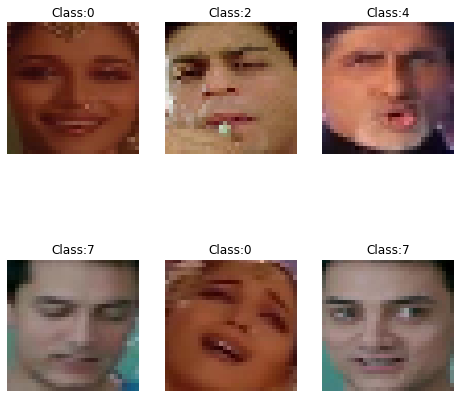

In [6]:
# Show sample images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X[ind,...],y[ind], row=2,col=3)

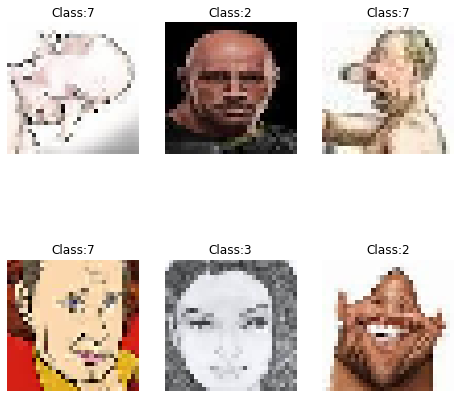

In [7]:
# Show sample images
ind = np.random.randint(0,y_cfw.shape[0],6)
disply_images(X_cfw[ind,...],y_cfw[ind], row=2,col=3)

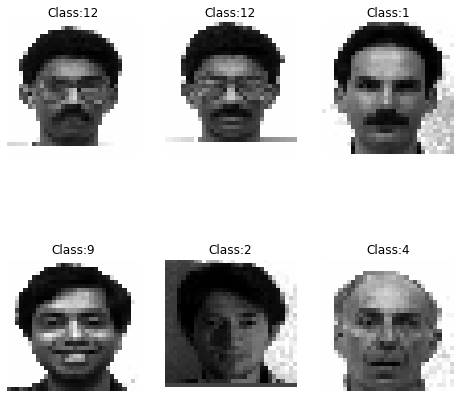

In [8]:
# Show sample images
ind = np.random.randint(0,y_yale.shape[0],6)
disply_images(X_yale[ind,...],y_yale[ind], row=2,col=3)

# Features
    You are provided 6 Features. These features are:
   - Eigen Faces / PCA 
   - Kernel PCA
   - Fisher Face / LDA
   - Kernel Fisher Face
   - VGG Features 
   - Resnet Features

**VGG and Resnet features are last layer features learned by training a model for image classification**
    
---


In [9]:
# Flatten to apply PCA/LDA
X = X.reshape((N,H*W*C))

In [10]:
# Flatten to apply PCA/LDA
X_cfw = X_cfw.reshape((N_cfw,H_cfw*W_cfw*C_cfw))

In [11]:
# Flatten to apply PCA/LDA
X_yale = X_yale.reshape((N_yale,H_yale*W_yale*C_yale))

###  1. Eigen Face:
Use principal component analysis to get the eigen faces. 
Go through the [documentation](!http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on how to use it

In [12]:
def get_pca(X,k):
    """
        Get PCA of K dimension using the top eigen vectors 
    """
    pca = PCA(n_components=k)
    pca.fit(X)
    return pca

###  2. Kernel Face:
Use Kernel principal component analysis to get the eigen faces. 

There are different kernels that can be used. Eg. Poly, rbf, sigmoid. Choose the whichever gives the best result or representation. See [link](!https://data-flair.training/blogs/svm-kernel-functions/) for better understanding of these kernels  

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA) on how to use it different kernels in Sklearn. 

In [13]:
def get_kernel_pca(X, k,kernel='rbf', degree=3):
    """
        Get PCA of K dimension using the top eigen vectors 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use (“linear” | “poly” | “rbf” | “sigmoid” | “cosine” )
        @param: d => Degree for poly kernels. Ignored by other kernels
    """
    kpca = KernelPCA(n_components=k,kernel=kernel,degree=degree)
    kpca.fit(X)
    return kpca

### 3. Fisher Face
Another method similar to the eigenface technique is `fisherfaces` which uses linear discriminant analysis.
This method for facial recognition is less sensitive to variation in lighting and pose of the face than using eigenfaces. Fisherface uses labelled data to retain more of the class-specific information during the dimension reduction stage.

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) on how to use it different kernels in Sklearn. 

In [14]:
def get_lda(X,y,k):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
    """
    lda = LDA(n_components=k)
    lda.fit(X, y)
    return lda

### 4. Kernel Fisher Face
Use LDA using different kernels similiar to KernelPCA. Here the input is directly transformed instead of using the kernel trick.  

In [15]:
def get_kernel_lda(X,y,k,kernel='rbf',degree=3):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use ( “poly” | “rbf” | “sigmoid”)
    """
    # Transform  input
    if kernel == "poly":
        X_transformed = X**degree
    elif kernel == "rbf":
        var = np.var(X)
        X_transformed= np.exp(-X/(2*var))
    elif kernel == "sigmoid":
        X_transformed = np.tanh(X)
    else: 
        raise NotImplementedError("Kernel {} Not defined".format(kernel))
        
    klda = LDA(n_components=k)
    klda.fit(X_transformed,y)
    return klda

### 5. VGG Features
VGG Neural Networks a 19 layer CNN architecture introduced by Andrew Zisserman([Link](!https://arxiv.org/pdf/1409.1556.pdf) to paper). We are providing you with the last fully connected layer of this model.

The model was trained for face classification on each dataset and each feature the dimension of 4096.

In [16]:
def get_vgg_features(dirpath):
    features = np.load(os.path.join(dirpath,"VGG19_features.npy"))
    return features

### 6. Resnet Features

[Residual neural networks](!https://arxiv.org/pdf/1512.03385.pdf) are CNN with large depth, to effectively train these netwrorks they utilize skip connections, or short-cuts to jump over some layers. This helps solving [vanishing gradient problem](!https://en.wikipedia.org/wiki/Vanishing_gradient_problem) 

A 50 layer resnet model was trained for face classification on each dataset. Each feature the dimension of 2048

In [17]:
def get_resnet_features(dirpath):
    features = np.load(os.path.join(dirpath,"resnet50_features.npy"))
    return features

# Questions

1(a). What are eigen faces? 

___________________________


Eigenface  is  a  method  that  is  useful  for  face  recognition
and  detection  by  determining  the  variance  of  faces  in  a
collection of face images and use those variances to encode
and decode a face in a machine learning way without the full
information reducing computation and space complexity.

1(b).  How many eigen vec-tors/faces are required to “satisfactorily” reconstruct a  person  in  these  three  datasets? (Don’t  forget  to make your argument based on eigen value spectrum) Show appropriate graphs, qualitative examples andmake a convincing argument.

1)  IMFDB - 80 <br/>
2)  IIIT-CFW - 130 <br/>
3)  Yale - 20 <br/>

In [18]:
# Compute your features 
# eg.
k_lda_imfdb = get_kernel_lda(X,y,3)
X_3D = k_lda_imfdb.transform(X)

k_lda_cfw = get_kernel_lda(X_cfw,y_cfw,3)
X_cfw_3D = k_lda_cfw.transform(X_cfw)

k_lda_yale = get_kernel_lda(X_yale,y_yale,3)
X_yale_3D = k_lda_yale.transform(X_yale)

In [19]:
def plot_scatterplot(X_3D, y, dataset):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X_3D[:,0],X_3D[:,1],X_3D[:,2],c=y)
    legend = ax.legend(*scatter.legend_elements(),loc=2, title="Classes")
    ax.add_artist(legend)
    plt.title("3D representation of {}".format(dataset))
    plt.show()

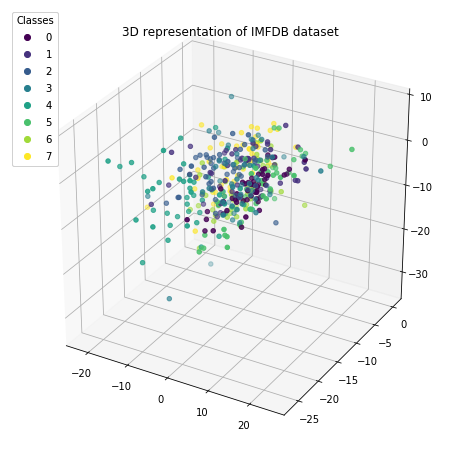

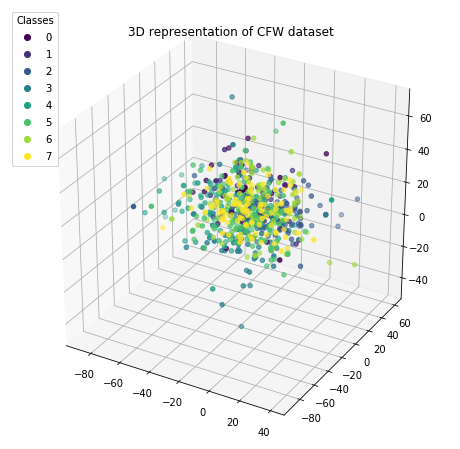

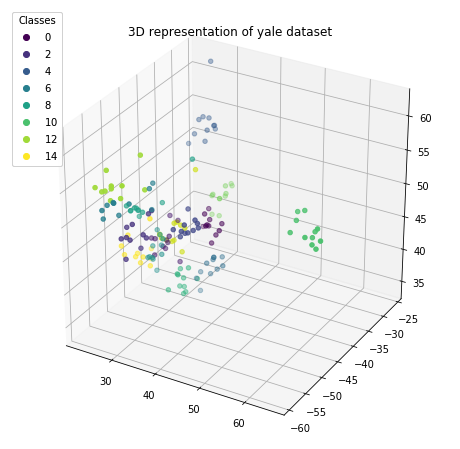

In [20]:
# Create a scatter plot  
plot_scatterplot(X_3D, y, "IMFDB dataset")
plot_scatterplot(X_cfw_3D, y_cfw, "CFW dataset")
plot_scatterplot(X_yale_3D, y_yale, "yale dataset")


In [21]:
# Code for plotting eigen value spectrum
def plot_eigen_value_spectrum(X, dataset):
    cov_mat = np.cov(X)
    eig_vals, _ = np.linalg.eig(cov_mat)
    eig_vals = sorted(eig_vals, reverse=True)
    x = np.arange(1, 1+len(eig_vals))

    fig = plt.figure(figsize = (12,6))
    ax = fig.add_subplot()
    ax.stem(np.arange(len(x)),eig_vals, use_line_collection=True)
    plt.title("Eigen value spectrum for {}".format(dataset))
    plt.xlabel("Eigen value number")
    plt.ylabel("Eigen value")
    fig.show()


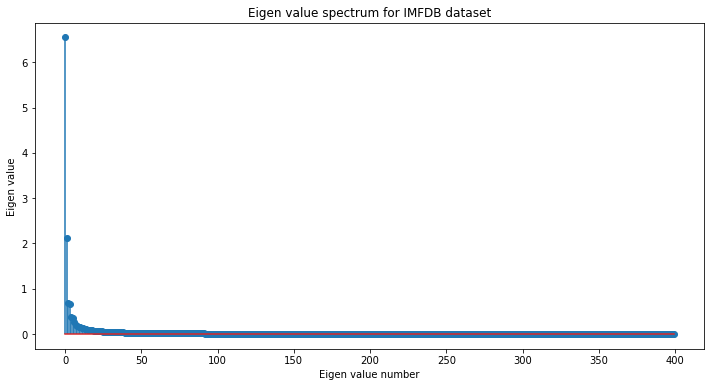

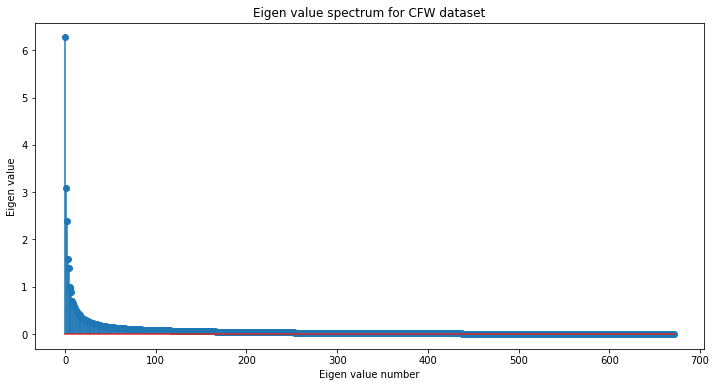

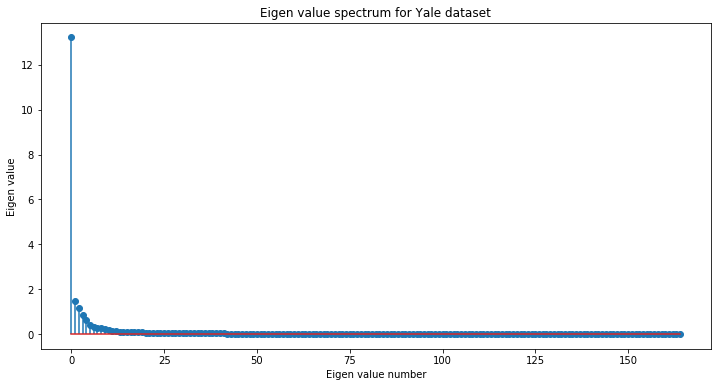

In [22]:
# Plot the eigen value spectrum
plot_eigen_value_spectrum(X, "IMFDB dataset")
plot_eigen_value_spectrum(X_cfw, "CFW dataset")
plot_eigen_value_spectrum(X_yale, "Yale dataset")

1(c). Reconstruct  the  image  back for each case


In [23]:
def reconstruct_images(X, k):
    """
        Reconstruct the images back by just using the selected principal components. 


        You have to write the code in this code block.
        You can change the functions provided above (eg, get_pca, get_lda) for your use case. 
            
        @params: 
                Input parameters

        @return reconstructed_X => reconstructed image
        
    """
    pca = get_pca(X, k)
    X_k = pca.transform(X)
    reconstruct_X = pca.inverse_transform(X_k)
    
    return reconstruct_X

In [24]:
def display_results(X, y, k, N, H, W, C):
    X_reconstructed = reconstruct_images(X, k)

    # Display random images
    ind = np.random.randint(0,y.shape[0],6)
    X_reconstructed_3D = X_reconstructed.reshape((N, H, W, C))
    print(X_reconstructed_3D.shape)
    disply_images(X_reconstructed_3D[ind,...],y[ind],row=2,col=3)

    # Show the reconstruction error
    print(np.sqrt(np.mean((X - X_reconstructed)**2)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(400, 32, 32, 3)


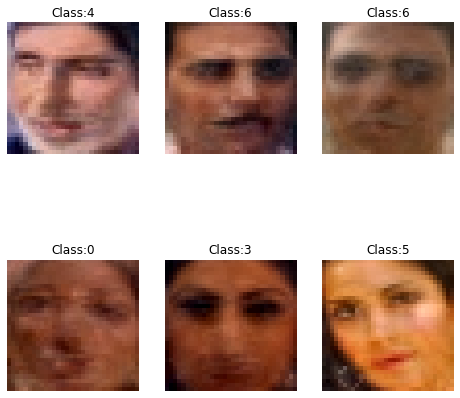

0.05013703064503904


In [25]:
display_results(X, y, 80, N, H, W, C)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(672, 32, 32, 3)


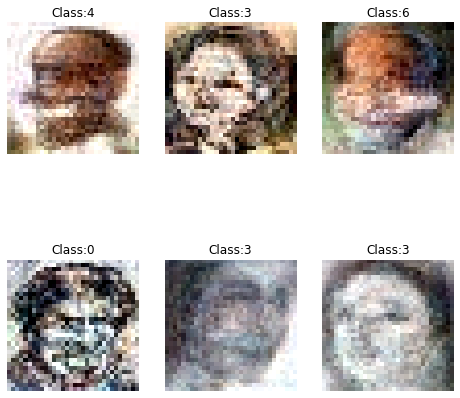

0.12402546242392928


In [26]:
display_results(X_cfw, y_cfw, 130, N_cfw, H_cfw, W_cfw, C_cfw)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(165, 32, 32, 3)


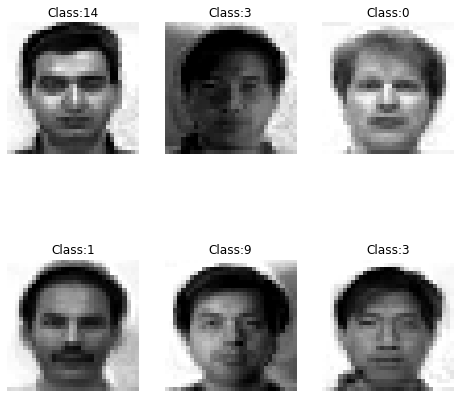

0.09753234235538859


In [27]:
display_results(X_yale, y_yale, 20, N_yale, H_yale, W_yale, C_yale)

1(d). Which person/identity is difficult to represent com-pactly with fewer eigen vectors?  Why is that?  Explain with your empirical observations and intuitive answers

IIIT-CFW Dataset is most difficult to represent compactly. This  dataset  has  high  variance  in  images  due  to  which  it is  hard  to  compactly  represent  them.  This  is  because  of their shapes of faces, color distribution, sharp edges and that cartoons have more distinct features than human faces (which have  common  features  like  nose,  eyes  etc.).  It  can  also  be seen from its eigen value spectrum that more eigen vectors are  required  to  represent  this  dataset.  Also,  reconstruction error is highest for this dataset.<br/>
Identities   which   are   hard   to   represent   compactly   are decided  by  reconstruction  error.<br/>
1)  IMFDB - Shilpa Shetty <br/>
2)  IIIT-CFW - Narendra Modi <br/>
3)  Yale - Class 7 <br/>

In [28]:
def get_class_data(X, y, class_label):
    return X[y==class_label]

In [29]:
def get_reconstruction_error_classwise(X, y, red_dim):
    labels = np.unique(y)
    pca = get_pca(X, red_dim)
    errors = {}

    for label in labels:
        data = get_class_data(X, y, label)
        transformed_data = pca.transform(data)
        reconstructed_data = pca.inverse_transform(transformed_data)
        error = np.sqrt(np.mean((data - reconstructed_data)**2))
        errors[label] = error
        print("Reconstruction error for class {} is {}".format(label, error))
    max_error_class = max(errors.items(), key=operator.itemgetter(1))[0]
    print("Max reconstruction error is for class {} with error {}".format(max_error_class, errors[max_error_class]))

In [30]:
# code goes here
print("IMFDB Dataset")
get_reconstruction_error_classwise(X, y, 80)

print()
print("CFW Dataset")
get_reconstruction_error_classwise(X_cfw, y_cfw, 130)

print()
print("Yale Dataset")
get_reconstruction_error_classwise(X_yale, y_yale, 20)


IMFDB Dataset
Reconstruction error for class 0 is 0.045266001916259575
Reconstruction error for class 1 is 0.049095322808678246
Reconstruction error for class 2 is 0.05007814380028845
Reconstruction error for class 3 is 0.052658242651128805
Reconstruction error for class 4 is 0.05152226103851585
Reconstruction error for class 5 is 0.050696307196363505
Reconstruction error for class 6 is 0.051186615367321366
Reconstruction error for class 7 is 0.050295389737895074
Max reconstruction error is for class 3 with error 0.052658242651128805

CFW Dataset
Reconstruction error for class 0 is 0.11361121168172349
Reconstruction error for class 1 is 0.12365977493419995
Reconstruction error for class 2 is 0.10852747706240978
Reconstruction error for class 3 is 0.11559668273468594
Reconstruction error for class 4 is 0.12391743619375717
Reconstruction error for class 5 is 0.13549784209739094
Reconstruction error for class 6 is 0.1334020741460789
Reconstruction error for class 7 is 0.12745348745831955


2(a). Use any classifier(MLP, Logistic regression, SVM, Decision Trees) and find the classification accuracy. 

2(b)Which method works well? Do a comparitivestudy. 


You already know the paper [Face Recognition Us-ing  Kernel  Methods](!http://face-rec.org/algorithms/Kernel/nips01.pdf) .See  this  as  an  example for empirical analysis of different features/classification.

In [31]:
# Constants
LOGISTIC_REGRESSION = "logistic regression"
MLP = "mlp"
SVM = "svm"
DECISION_TREE = "decision_tree"

models = {LOGISTIC_REGRESSION: LogisticRegression, MLP: MLPClassifier, SVM: SVC, DECISION_TREE: DecisionTreeClassifier}

In [32]:
# Define your classifier here. You can use libraries like sklearn to create your classifier 

class Classifier():
    def __init__(self, model_name, **kwargs):
#         super.__init__()
        self.model_name = model_name
        self.model_args = kwargs
    
    # Define your parameters eg, W,b, max_iterations etc.
    
    def classify(self,X):
        """
            Given an input X classify it into appropriate class. 
        """
        prediction = self.clf.predict(X)
        return prediction
        
    def confusion_matrix(self,pred,y):
        """
            A confusion matrix is a table that is often used to describe the performance of a classification
            model (or “classifier”) on a set of test data for which the true values are known.
            
            
            @return confusion_matrix => num_classesxnum_classes martix 
                where confusion_matrix[i,j] = number of prediction which are i and number of ground truth value equal j 
        
        """
        confusion_matrix = ConfusionMatrix(y, pred)
        return confusion_matrix
        
        
    def train(self,X_train,y_train):
        if self.model_name not in models.keys():
            print("Model not identified")
            return
        model = models[self.model_name]
        clf = model(**self.model_args)
        clf.fit(X_train, y_train)
        self.clf = clf
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        
    def validate(self,X_validate,y_validate, print_results=True, multiclass=True):
        """
            How good is the classifier on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters and judge the classification
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier validated. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        y_pred = self.classify(X_validate)
        
        # Create a confusion matrix
        self.confusionMatrix = self.confusion_matrix(y_pred, y_validate)
        
        # Calculate Validation accuracy 
        self.validation_accuracy = round(accuracy_score(y_validate, y_pred)*100, 2)
    
        # Calculate precision and recall
        if multiclass:
            self.precision = round(precision_score(y_validate, y_pred, average='macro'), 2)
            self.recall = round(recall_score(y_validate, y_pred, average='macro'), 2)
            self.f1 = round(f1_score(y_validate, y_pred, average='macro'), 2)
        else:
            self.precision = round(precision_score(y_validate, y_pred), 2)
            self.recall = round(recall_score(y_validate, y_pred), 2)
            self.f1 = round(f1_score(y_validate, y_pred), 2)
        
        # Calculate F1-score
        
        if print_results:
            print("Validation Accuracy is {}%".format(self.validation_accuracy))
            print("Precision is {} and recall is {}".format(self.precision, self.recall))
            print("F1 score is {}".format(self.f1))
    
        return self.confusionMatrix, self.validation_accuracy, self.f1

In [33]:
# Create a train and validation split to train your classifier 
X_train, X_val, y_train, y_val=train_test_split(X, y, test_size=0.2, random_state=1)

In [34]:
X_cfw_train, X_cfw_val, y_cfw_train, y_cfw_val=train_test_split(X_cfw, y_cfw, test_size=0.2, random_state=1)

In [35]:
X_yale_train, X_yale_val, y_yale_train, y_yale_val=train_test_split(X_yale, y_yale, test_size=0.2, random_state=1)

In [36]:
classifiers_imfdb = {}
print("IMFDB Dataset")
classifier = Classifier(LOGISTIC_REGRESSION, solver='newton-cg', max_iter=2000, multi_class='auto')
classifiers_imfdb['lr'] = classifier
classifier.train(X_train, y_train)
print()
print("Logistic Regression")
_,_,_ = classifier.validate(X_val, y_val)

classifier = Classifier(SVM, gamma='scale', kernel='poly', coef0=1)
classifiers_imfdb['svm'] = classifier
classifier.train(X_train, y_train)
print()
print("Support Vector Machine")
_,_,_ = classifier.validate(X_val, y_val)

classifier = Classifier(DECISION_TREE)
classifiers_imfdb['dt'] = classifier
classifier.train(X_train, y_train)
print()
print("Decision Tree")
_,_,_ = classifier.validate(X_val, y_val)

classifier = Classifier(MLP, hidden_layer_sizes=(100, 100, 100), max_iter=2000)
classifiers_imfdb['mlp'] = classifier
classifier.train(X_train, y_train)
print()
print("Multi Layer Perceptron")
_,_,_ = classifier.validate(X_val, y_val)

IMFDB Dataset

Logistic Regression
Validation Accuracy is 82.5%
Precision is 0.83 and recall is 0.84
F1 score is 0.83

Support Vector Machine
Validation Accuracy is 83.75%
Precision is 0.85 and recall is 0.84
F1 score is 0.83

Decision Tree
Validation Accuracy is 53.75%
Precision is 0.55 and recall is 0.54
F1 score is 0.54

Multi Layer Perceptron
Validation Accuracy is 81.25%
Precision is 0.8 and recall is 0.82
F1 score is 0.81


In [37]:
classifiers_cfw = {}
print("CFW Dataset")
classifier = Classifier(LOGISTIC_REGRESSION, solver='newton-cg', max_iter=2000, multi_class='auto')
classifiers_cfw['lr'] = classifier
classifier.train(X_cfw_train, y_cfw_train)
print()
print("Logistic Regression")
_,_,_ = classifier.validate(X_cfw_val, y_cfw_val)

classifier = Classifier(SVM, gamma='scale', kernel='poly', coef0=1, C=0.1)
classifiers_cfw['svm'] = classifier
classifier.train(X_cfw_train, y_cfw_train)
print()
print("Support Vector Machine")
_,_,_ = classifier.validate(X_cfw_val, y_cfw_val)

classifier = Classifier(DECISION_TREE)
classifiers_cfw['dt'] = classifier
classifier.train(X_cfw_train, y_cfw_train)
print()
print("Decision Tree")
_,_,_ = classifier.validate(X_cfw_val, y_cfw_val)

classifier = Classifier(MLP, hidden_layer_sizes=(100, 100, 100), max_iter=2000)
classifiers_cfw['mlp'] = classifier
classifier.train(X_cfw_train, y_cfw_train)
print()
print("Multi Layer Perceptron")
_,_,_ = classifier.validate(X_cfw_val, y_cfw_val)


CFW Dataset

Logistic Regression
Validation Accuracy is 62.96%
Precision is 0.59 and recall is 0.6
F1 score is 0.58

Support Vector Machine
Validation Accuracy is 68.15%
Precision is 0.65 and recall is 0.66
F1 score is 0.64

Decision Tree
Validation Accuracy is 34.81%
Precision is 0.3 and recall is 0.31
F1 score is 0.3

Multi Layer Perceptron
Validation Accuracy is 61.48%
Precision is 0.59 and recall is 0.58
F1 score is 0.57


In [38]:
classifiers_yale = {}
print("Yale Dataset")
classifier = Classifier(LOGISTIC_REGRESSION, solver='newton-cg', max_iter=2000, multi_class='auto')
classifiers_yale['lr'] = classifier
classifier.train(X_yale_train, y_yale_train)
print()
print("Logistic Regression")
_,_,_ = classifier.validate(X_yale_val, y_yale_val)

classifier = Classifier(SVM, kernel='linear')
classifiers_yale['svm'] = classifier
classifier.train(X_yale_train, y_yale_train)
print()
print("Support Vector Machine")
_,_,_ = classifier.validate(X_yale_val, y_yale_val)

classifier = Classifier(DECISION_TREE)
classifiers_yale['dt'] = classifier
classifier.train(X_yale_train, y_yale_train)
print()
print("Decision Tree")
_,_,_ = classifier.validate(X_yale_val, y_yale_val)

classifier = Classifier(MLP, hidden_layer_sizes=(100, 100, 100), max_iter=2000)
classifiers_yale['mlp'] = classifier
classifier.train(X_yale_train, y_yale_train)
print()
print("Multi Layer Perceptron")
_,_,_ = classifier.validate(X_yale_val, y_yale_val)


Yale Dataset

Logistic Regression
Validation Accuracy is 93.94%
Precision is 0.91 and recall is 0.89
F1 score is 0.9

Support Vector Machine
Validation Accuracy is 90.91%
Precision is 0.89 and recall is 0.85
F1 score is 0.86

Decision Tree
Validation Accuracy is 66.67%
Precision is 0.69 and recall is 0.63
F1 score is 0.61

Multi Layer Perceptron
Validation Accuracy is 96.97%
Precision is 0.98 and recall is 0.97
F1 score is 0.98


In [39]:
def concatenate_features(X1, X2):
    return np.concatenate((X1, X2), axis=1)

In [40]:
def show_table(table_vals):
    # table_vals contains dict (col->list of values of the column)
    df = pd.DataFrame(data=table_vals)
    display(HTML(df.to_html(index=False)))

In [41]:
def insert_in_dict(method, new_dims, error, accuracy, f1_score, table_dict):
    table_dict["Method"].append(method)
    table_dict["Reduced Dimension Space"].append(new_dims)
    table_dict["Classification Error"].append(error)
    table_dict["Accuracy"].append(accuracy)
    table_dict["F1 score"].append(f1_score)

In [42]:
def get_red_dim(method, X, y, dirpath, red_dim):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
    if method == 'pca':
        obj = get_pca(X_train, red_dim)
        return obj.transform(X_train), obj.transform(X_val), y_train, y_val
    elif method == 'kpca':
        obj = get_kernel_pca(X_train, red_dim)
        return obj.transform(X_train), obj.transform(X_val), y_train, y_val
    elif method == 'lda':
        obj = get_lda(X_train, y_train, red_dim)
        return obj.transform(X_train), obj.transform(X_val), y_train, y_val
    elif method == 'klda':
        obj = get_kernel_lda(X_train, y_train, red_dim)
        return obj.transform(X_train), obj.transform(X_val), y_train, y_val
    elif method == 'vgg':
        X_red = get_vgg_features(dirpath)
        return train_test_split(X_red, y, test_size=0.2, random_state=1)
    elif method == 'resnet':
        X_red = get_resnet_features(dirpath)
        return train_test_split(X_red, y, test_size=0.2, random_state=1)

In [43]:
def reduce_dimensions(methods, X, y, dirpath, red_dim):
    X_train = None
    X_val = None
    X_train = None
    X_val = None
    for methodd in methods:
        X_train1, X_val1, y_train, y_val = get_red_dim(methodd, X, y, dirpath, red_dim)
        if X_train is not None:
            X_train = concatenate_features(X_train, X_train1)
        else:
            X_train = X_train1
        if X_val is not None:
            X_val = concatenate_features(X_val, X_val1)
        else:
            X_val = X_val1
    return X_train, X_val, y_train, y_val

In [44]:
def update_table(table_dict, X, y, classifiers_dict, classifier_name, method, red_dim_methods, dirpath, red_dim):
    X_train, X_val, y_train, y_val = reduce_dimensions(red_dim_methods, X, y, dirpath, red_dim)

    red_dim = X_train.shape[1]
    classifier = classifiers_dict[classifier_name]
    try:
        classifier.clf = clone(classifier.clf)
    except:
        pass
    classifier.train(X_train, y_train)
    _, acc, _ = classifier.validate(X_train, y_train, print_results=False)
    error = (100-acc)/100
    _, acc, f1 = classifier.validate(X_val, y_val, print_results=False)
    insert_in_dict(method, red_dim, error, acc, f1, table_dict)


In [45]:
def classify(X, y, classifiers_dict, dirpath, red_dim):
    table_dict = {"Method":[], "Reduced Dimension Space":[], "Classification Error":[], "Accuracy":[], "F1 score":[]}
    
    update_table(table_dict, X, y, classifiers_dict, "svm", "(LDA+PCA)+SVM", ["lda", "pca"], dirpath, red_dim)
    
    update_table(table_dict, X, y, classifiers_dict, "mlp", "ResNet+MLP", ["resnet"], dirpath, red_dim)

    update_table(table_dict, X, y, classifiers_dict, "lr", "(VGG+ResNet)+LR", ["vgg", "resnet"], dirpath, red_dim)

    update_table(table_dict, X, y, classifiers_dict, "svm", "(VGG+ResNet)+SVM", ["vgg", "resnet"], dirpath, red_dim)

    update_table(table_dict, X, y, classifiers_dict, "mlp", "All features+MLP", ["vgg", "resnet", "pca", "kpca", "lda", "klda"], dirpath, red_dim)

    update_table(table_dict, X, y, classifiers_dict, "lr", "(KLDA+ResNet)+LR", ["klda", "resnet"], dirpath, red_dim)

    update_table(table_dict, X, y, classifiers_dict, "svm", "(KPCA+LDA)+SVM", ["kpca", "lda"], dirpath, red_dim)

    update_table(table_dict, X, y, classifiers_dict, "lr", "KLDA+LR", ["klda"], dirpath, red_dim)

    show_table(table_dict)
    

In [46]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, classification error, accuracy, f1-score

# Print the table. (You can use Pandas)
print("IMFDB Dataset")
classify(X, y, classifiers_imfdb, './dataset/IMFDB', 80)
print("CFW Dataset")
classify(X_cfw, y_cfw, classifiers_cfw, './dataset/IIIT-CFW', 120)
print("Yale Dataset")
classify(X_yale, y_yale, classifiers_yale, './dataset/Yale_face_database', 30)


IMFDB Dataset


Method,Reduced Dimension Space,Classification Error,Accuracy,F1 score
(LDA+PCA)+SVM,87,0.0031,77.50,0.78
ResNet+MLP,2048,0.0000,96.25,0.96
(VGG+ResNet)+LR,6144,0.0000,100.00,1.00
(VGG+ResNet)+SVM,6144,0.0000,98.75,0.98
All features+MLP,6318,0.0000,100.00,1.00
(KLDA+ResNet)+LR,2055,0.0000,97.50,0.97
(KPCA+LDA)+SVM,87,0.0094,68.75,0.71
KLDA+LR,7,0.2781,62.50,0.60


CFW Dataset


Method,Reduced Dimension Space,Classification Error,Accuracy,F1 score
(LDA+PCA)+SVM,127,0.0447,51.85,0.49
ResNet+MLP,2048,0.0000,96.30,0.96
(VGG+ResNet)+LR,6144,0.0000,99.26,0.99
(VGG+ResNet)+SVM,6144,0.0112,100.00,1.00
All features+MLP,6398,0.0000,99.26,0.99
(KLDA+ResNet)+LR,2055,0.0000,94.07,0.93
(KPCA+LDA)+SVM,127,0.0354,34.07,0.31
KLDA+LR,7,0.2551,29.63,0.26


Yale Dataset


Method,Reduced Dimension Space,Classification Error,Accuracy,F1 score
(LDA+PCA)+SVM,44,0.0,96.97,0.92
ResNet+MLP,2048,0.0,96.97,0.96
(VGG+ResNet)+LR,6144,0.0,100.00,1.00
(VGG+ResNet)+SVM,6144,0.0,100.00,1.00
All features+MLP,6232,0.0,100.00,1.00
(KLDA+ResNet)+LR,2062,0.0,100.00,1.00
(KPCA+LDA)+SVM,44,0.0,100.00,1.00
KLDA+LR,14,0.0,93.94,0.95


In [47]:
def get_confusion_matrix(X, y, classifier, dirpath, red_dim, methods):
    X_train, X_val, y_train, y_val = reduce_dimensions(methods, X, y, dirpath, red_dim)
    try:
        classifier.clf = clone(classifier.clf)
    except:
        pass
    classifier.train(X_train, y_train)
    confustion_matrix, _, _ = classifier.validate(X_val, y_val, print_results=False)
    return confustion_matrix

In [48]:
def print_confusion_matrix(confusion_matrix):
    plt.figure(figsize = (5,5))
    ax = sn.heatmap(confusion_matrix, annot=True,annot_kws={"size": 12}, fmt='g')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()

Best model for IMFDB Dataset is Linear regression on VGG+ResNet features


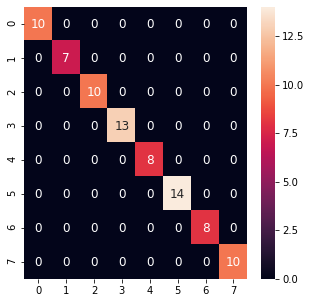

Best model for CFW Datset is Support Vector Machine on VGG+ResNet features


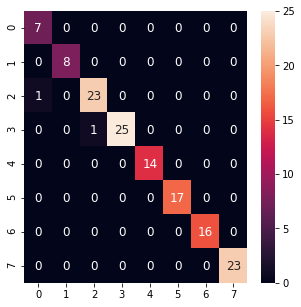

Best model for Yale Dataset is Support Vector Machine on Kernel PCA+LDA


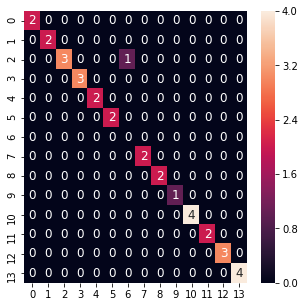

In [49]:
# For each dataset print the confusion matrix for the best model
dirpath = './dataset/IMFDB'
print("Best model for IMFDB Dataset is Linear regression on VGG+ResNet features")
classifier = classifiers_imfdb['lr']
confusion_matrix = get_confusion_matrix(X, y, classifier, dirpath, 80, ["vgg", "resnet"])
print_confusion_matrix(confusion_matrix)

dirpath = './dataset/IIIT-CFW'
print("Best model for CFW Datset is Support Vector Machine on VGG+ResNet features")
classifier = classifiers_imfdb['svm']
confusion_matrix = get_confusion_matrix(X_cfw, y_cfw, classifier, dirpath, 130, ["vgg", "resnet"])
print_confusion_matrix(confusion_matrix)

print("Best model for Yale Dataset is Support Vector Machine on Kernel PCA+LDA")
classifier = classifiers_imfdb['lr']
confusion_matrix = get_confusion_matrix(X_yale, y_yale, classifier, None, 30, ["kpca", "lda"])
print_confusion_matrix(confusion_matrix)


3. Similiar to 1(b) use t-SNE based visilization of faces?  Does it makesense?  Do you see similar people coming together?or something else?  Can you do visualization datasetwise and combined? Here you will use a popular implementation.(Worth  reading and understanding  t-SNE.  We  will not discuss it in the class and out of scope for thiscourse/exams. <br/>


After doing t-SNE based visualisation for each dataset separately, clustering is not observed since it is an unsupervised algorithm which does not use information from the class labels. But when we do this on combined dataset, we see points corresponding to same dataset are closer (Figure 8 for 2D and 9 for 3D). If we apply lda and then do tsne then, clustering is observed because lda is supervised algorithm

In [50]:
X_combined = np.concatenate((X, X_cfw, X_yale), axis=0)
y_combined = np.zeros(X.shape[0])
y_combined = np.concatenate((y_combined, 1+np.zeros(X_cfw.shape[0])), axis=0)
y_combined = np.concatenate((y_combined, 2+np.zeros(X_yale.shape[0])), axis=0)


In [51]:
# Compute TSNE for different features and create a scatter plot

k = 3 # Number of components in TSNE
# Compute
X_TSNE_imfdb = TSNE(n_components=k).fit_transform(X)
X_TSNE_cfw = TSNE(n_components=k).fit_transform(X_cfw)
X_TSNE_yale = TSNE(n_components=k).fit_transform(X_yale)
X_TSNE_comb = TSNE(n_components=k).fit_transform(X_combined)


In [52]:
# Compute TSNE for different features and create a scatter plot

k = 2 # Number of components in TSNE
# Compute
X_TSNE_imfdb_2d = TSNE(n_components=k).fit_transform(X)
X_TSNE_cfw_2d = TSNE(n_components=k).fit_transform(X_cfw)
X_TSNE_yale_2d = TSNE(n_components=k).fit_transform(X_yale)
X_TSNE_comb_2d = TSNE(n_components=k).fit_transform(X_combined)


In [53]:
def plot_2d_scatterplot(X_2D, y, dataset):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(X_2D[:,0],X_2D[:,1],c=y)
    legend = ax.legend(*scatter.legend_elements(),loc=2, title="Classes")
    ax.add_artist(legend)
    plt.title("2D representation of {}".format(dataset))
    plt.show()

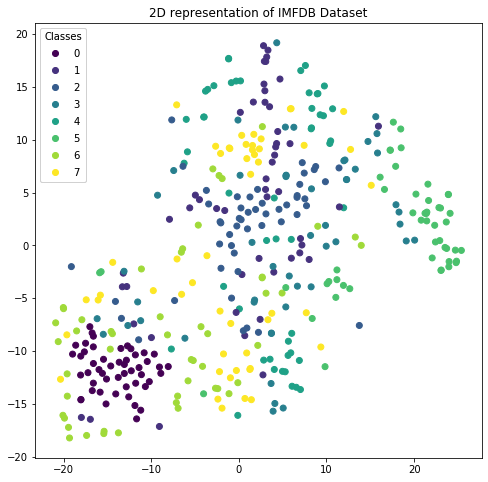

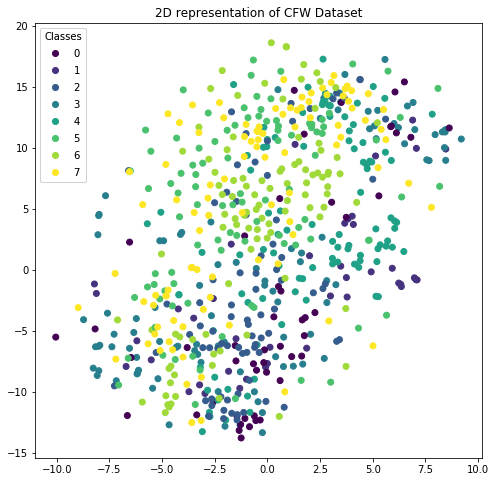

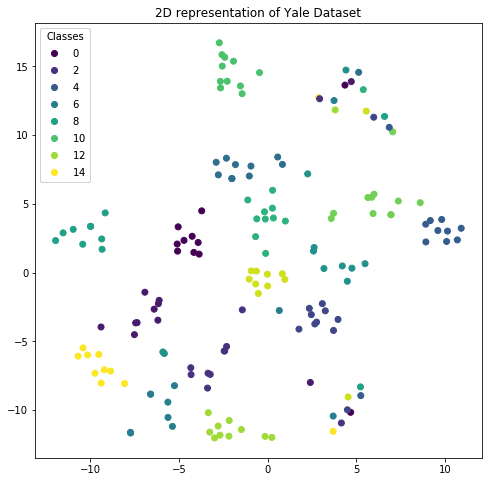

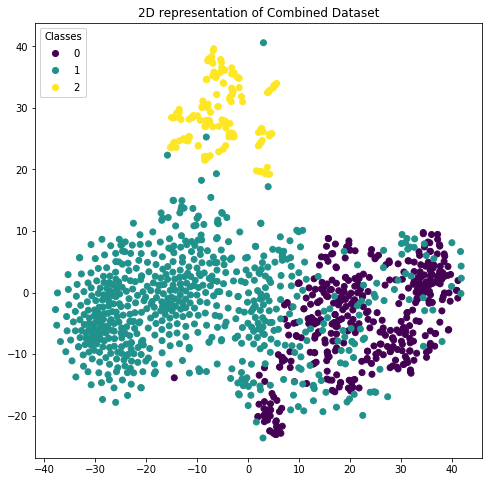

In [54]:
plot_2d_scatterplot(X_TSNE_imfdb_2d, y, "IMFDB Dataset")
plot_2d_scatterplot(X_TSNE_cfw_2d, y_cfw, "CFW Dataset")
plot_2d_scatterplot(X_TSNE_yale_2d, y_yale, "Yale Dataset")
plot_2d_scatterplot(X_TSNE_comb_2d, y_combined, "Combined Dataset")
# Plot the representation in 2d/3d


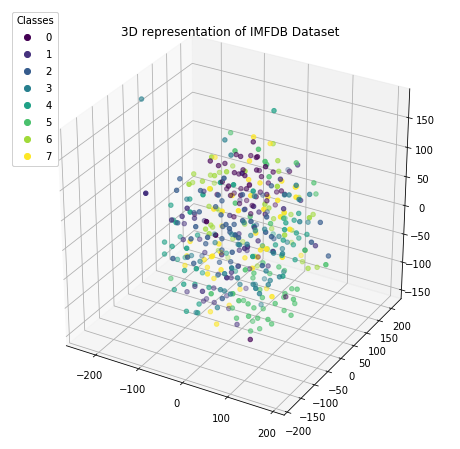

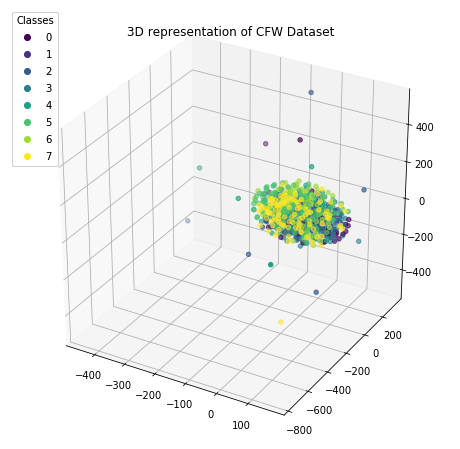

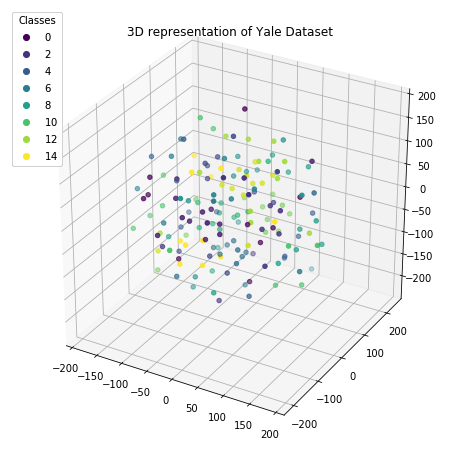

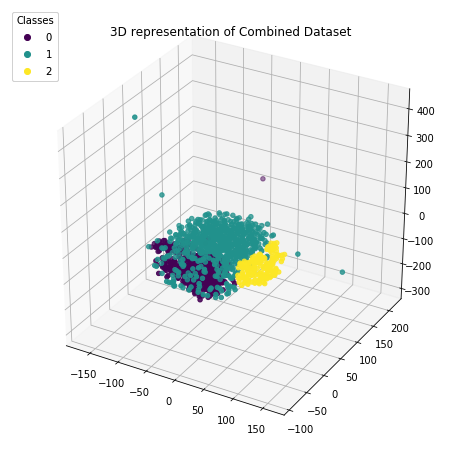

In [55]:
plot_scatterplot(X_TSNE_imfdb, y, "IMFDB Dataset")
plot_scatterplot(X_TSNE_cfw, y_cfw, "CFW Dataset")
plot_scatterplot(X_TSNE_yale, y_yale, "Yale Dataset")
plot_scatterplot(X_TSNE_comb, y_combined, "Combined Dataset")
# Plot the representation in 2d/3d


In [56]:
lda_imfdb = get_lda(X, y, 7)
X_lda = lda_imfdb.transform(X)
lda_cfw = get_lda(X_cfw, y_cfw, 7)
X_lda_cfw = lda_cfw.transform(X_cfw)
lda_yale = get_lda(X_yale, y_yale, 14)
X_lda_yale = lda_yale.transform(X_yale)
lda_comb = get_lda(X_combined, y_combined, 28)
X_lda_comb = lda_comb.transform(X_combined)

In [57]:
k=2
X_TSNE_imfdb_2d_lda = TSNE(n_components=k).fit_transform(X_lda)
X_TSNE_cfw_2d_lda = TSNE(n_components=k).fit_transform(X_lda_cfw)
X_TSNE_yale_2d_lda = TSNE(n_components=k).fit_transform(X_lda_yale)
X_TSNE_comb_2d_lda = TSNE(n_components=k).fit_transform(X_lda_comb)

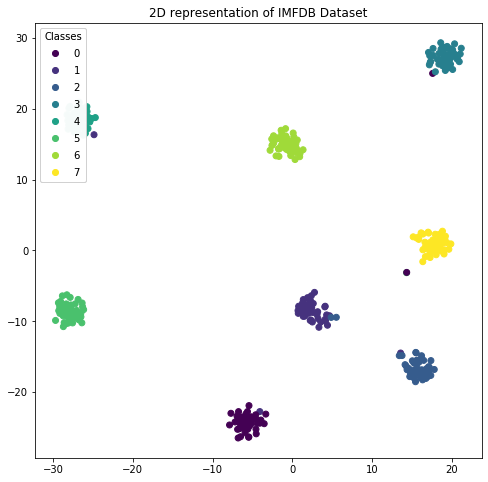

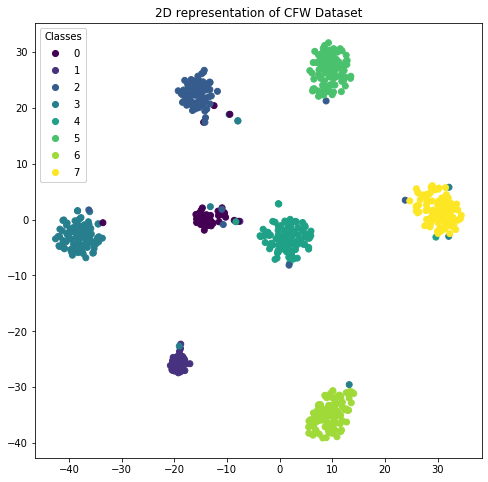

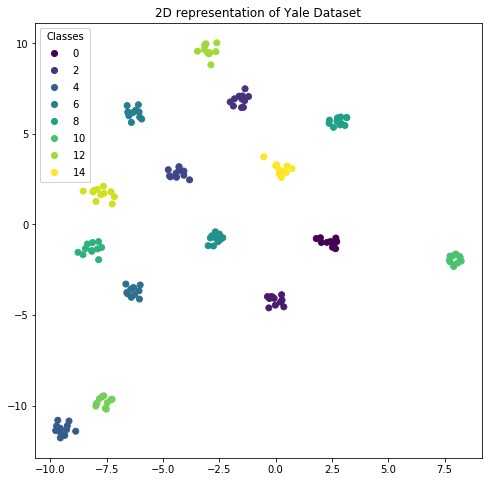

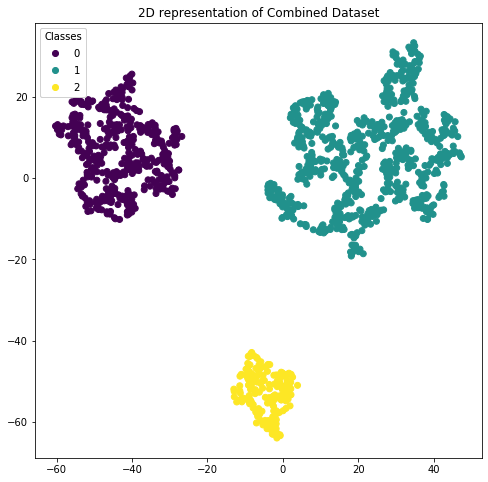

In [58]:
plot_2d_scatterplot(X_TSNE_imfdb_2d_lda, y, "IMFDB Dataset")
plot_2d_scatterplot(X_TSNE_cfw_2d_lda, y_cfw, "CFW Dataset")
plot_2d_scatterplot(X_TSNE_yale_2d_lda, y_yale, "Yale Dataset")
plot_2d_scatterplot(X_TSNE_comb_2d_lda, y_combined, "Combined Dataset")
# Plot the representation in 2d/3d

4.`face`  is  used  for  verification.   

4(a) How do we formulate the problem using KNN 

4(b) How do we analyze the performance ? suggest  the  metrics  (like  accuracy) that is appropriate for this task.

_______________________________________________________________________

4(c)Show empirical re-sults  with  all  the  representations

In [59]:
class FaceVerification():
    def __init__(self, **kwargs):
        self.model_args = kwargs
    
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def classify(self,X):
        """
            Given an input X find if the class id is correct or not.
            
            @return verfication_results => N vector containing True or False. 
                    If the class-id matches with your prediction then true else false.   
        """
        predict = self.clf.predict(X)
        return predict
        
    def train(self,X_train,y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your verification system will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        clf = KNeighborsClassifier(**self.model_args)
        clf.fit(X_train, y_train)
        self.clf = clf
        
    def validate(self,X_validate,y_validate, print_results=True):
        """
            How good is your system on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        y_pred = self.classify(X_validate)
        
        # Calculate Validation accuracy 
        self.validation_accuracy = round(accuracy_score(y_validate, y_pred)*100, 2)
    
        # Calculate precision and recall 
        self.precision = round(precision_score(y_validate, y_pred, average='macro'), 2)
        self.recall = round(recall_score(y_validate, y_pred, average='macro'), 2)
        
        # Calculate F1-score
        self.f1 = round(f1_score(y_validate, y_pred, average='macro'), 2)
        
        if print_results:
            print("Validation Accuracy is {}%".format(self.validation_accuracy))
            print("Precision is {} and recall is {}".format(self.precision, self.recall))
            print("F1 score is {}".format(self.f1))
    
        return self.validation_accuracy, self.precision

In [60]:
# Create a train and validation split and show your results
print("IMFDB Dataset")
classifier = FaceVerification(n_neighbors=3, algorithm='auto')
classifier.train(X_train, y_train)
acc, _ = classifier.validate(X_train, y_train, print_results=False)
print("Verification error is {}".format((100-acc)/100))
_,_ = classifier.validate(X_val, y_val)

print("CFW Dataset")
classifier.clf = clone(classifier.clf)
classifier.train(X_cfw_train, y_cfw_train)
acc, _ = classifier.validate(X_cfw_train, y_cfw_train, print_results=False)
print("Verification error is {}".format((100-acc)/100))
_,_ = classifier.validate(X_cfw_val, y_cfw_val)

print("Yale Dataset")
classifier.clf = clone(classifier.clf)
classifier.train(X_yale_train, y_yale_train)
acc, _ = classifier.validate(X_yale_train, y_yale_train, print_results=False)
print("Verification error is {}".format((100-acc)/100))
_,_ = classifier.validate(X_yale_val, y_yale_val)


IMFDB Dataset
Verification error is 0.23120000000000004
Validation Accuracy is 60.0%
Precision is 0.65 and recall is 0.6
F1 score is 0.57
CFW Dataset
Verification error is 0.5177
Validation Accuracy is 31.85%
Precision is 0.55 and recall is 0.31
F1 score is 0.25
Yale Dataset
Verification error is 0.09090000000000004
Validation Accuracy is 90.91%
Precision is 0.94 and recall is 0.92
F1 score is 0.91


In [61]:
def insert_in_dict_knn(method, new_dims, error, accuracy, f1_score, table_dict):
    table_dict["Method"].append(method)
    table_dict["Reduced Dimension Space"].append(new_dims)
    table_dict["Verification Error"].append(error)
    table_dict["Accuracy"].append(accuracy)
    table_dict["Precision"].append(f1_score)

In [62]:
def update_table_knn(table_dict, X, y, classifier, method, red_dim_methods, dirpath, red_dim):
    X_train, X_val, y_train, y_val = reduce_dimensions(red_dim_methods, X, y, dirpath, red_dim)
    red_dim = X_train.shape[1]
    try:
        classifier.clf = clone(classifier.clf)
    except:
        pass
    classifier.train(X_train, y_train)
    acc, _ = classifier.validate(X_train, y_train, print_results=False)
    error = (100-acc)/100
    acc, precision_score = classifier.validate(X_val, y_val, print_results=False)
    insert_in_dict_knn(method, red_dim, error, acc, precision_score, table_dict)


In [63]:
def classify_knn(X, y, classifier, dirpath, red_dim):
    table_dict = {"Method":[], "Reduced Dimension Space":[], "Verification Error":[], "Accuracy":[], "Precision":[]}
    
    update_table_knn(table_dict, X, y, classifier, "LDA+PCA", ["lda", "pca"], dirpath, red_dim)
    
    update_table_knn(table_dict, X, y, classifier, "ResNet", ["resnet"], dirpath, red_dim)

    update_table_knn(table_dict, X, y, classifier, "VGG+ResNet", ["vgg", "resnet"], dirpath, red_dim)

    update_table_knn(table_dict, X, y, classifier, "All features", ["vgg", "resnet", "pca", "kpca", "lda", "klda"], dirpath, red_dim)

    update_table_knn(table_dict, X, y, classifier, "KLDA+ResNet", ["klda", "resnet"], dirpath, red_dim)

    update_table_knn(table_dict, X, y, classifier, "KPCA+LDA", ["kpca", "lda"], dirpath, red_dim)

    update_table_knn(table_dict, X, y, classifier, "KLDA", ["klda"], dirpath, red_dim)

    show_table(table_dict)
    
    

In [64]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, verification error, accuracy, precision

# Print the table. (You can use Pandas)
# classifier = FaceVerification(n_neighbors=3, algorithm='auto')
for n_neighbors in range(3,6,2):
    print("For number of neighbors = {}".format(n_neighbors))
    classifier = FaceVerification(n_neighbors=n_neighbors, algorithm='auto')
    print("IMFDB Dataset")
    classify_knn(X, y, classifier, './dataset/IMFDB', 80)
    print("CFW Dataset")
    classify_knn(X_cfw, y_cfw, classifier, './dataset/IIIT-CFW', 120)
    print("Yale Dataset")
    classify_knn(X_yale, y_yale, classifier, './dataset/Yale_face_database', 30)


For number of neighbors = 3
IMFDB Dataset


Method,Reduced Dimension Space,Verification Error,Accuracy,Precision
LDA+PCA,87,0.0344,80.00,0.84
ResNet,2048,0.0219,95.00,0.94
VGG+ResNet,6144,0.0094,98.75,0.99
All features,6318,0.0062,98.75,0.99
KLDA+ResNet,2055,0.0156,96.25,0.96
KPCA+LDA,87,0.0094,77.50,0.84
KLDA,7,0.2406,50.00,0.47


CFW Dataset


Method,Reduced Dimension Space,Verification Error,Accuracy,Precision
LDA+PCA,127,0.1434,43.70,0.47
ResNet,2048,0.0223,97.04,0.95
VGG+ResNet,6144,0.0205,98.52,0.98
All features,6398,0.0093,83.70,0.82
KLDA+ResNet,2055,0.0112,80.74,0.82
KPCA+LDA,127,0.0354,37.04,0.39
KLDA,7,0.2160,25.19,0.26


Yale Dataset


Method,Reduced Dimension Space,Verification Error,Accuracy,Precision
LDA+PCA,44,0.0833,93.94,0.95
ResNet,2048,0.0076,100.00,1.00
VGG+ResNet,6144,0.0000,96.97,0.97
All features,6232,0.0000,100.00,1.00
KLDA+ResNet,2062,0.0000,100.00,1.00
KPCA+LDA,44,0.0000,96.97,0.93
KLDA,14,0.0152,96.97,0.93


For number of neighbors = 5
IMFDB Dataset


Method,Reduced Dimension Space,Verification Error,Accuracy,Precision
LDA+PCA,87,0.0344,78.75,0.82
ResNet,2048,0.0281,96.25,0.96
VGG+ResNet,6144,0.0125,98.75,0.99
All features,6318,0.0094,98.75,0.99
KLDA+ResNet,2055,0.0156,97.50,0.97
KPCA+LDA,87,0.0250,80.00,0.85
KLDA,7,0.3219,47.50,0.55


CFW Dataset


Method,Reduced Dimension Space,Verification Error,Accuracy,Precision
LDA+PCA,127,0.1471,44.44,0.53
ResNet,2048,0.0205,97.78,0.97
VGG+ResNet,6144,0.0186,99.26,0.99
All features,6398,0.0130,83.70,0.82
KLDA+ResNet,2055,0.0223,82.96,0.83
KPCA+LDA,127,0.0391,39.26,0.40
KLDA,7,0.2607,25.93,0.25


Yale Dataset


Method,Reduced Dimension Space,Verification Error,Accuracy,Precision
LDA+PCA,44,0.0682,93.94,0.95
ResNet,2048,0.0076,100.00,1.00
VGG+ResNet,6144,0.0227,96.97,0.97
All features,6232,0.0000,100.00,1.00
KLDA+ResNet,2062,0.0000,100.00,1.00
KPCA+LDA,44,0.0000,96.97,0.93
KLDA,14,0.0076,93.94,0.91


### Extenstion / Application
    Create a system for any one of the following problems:

- Politicians  vs  Filmstars  in  a  public  data  set.   (eg.LFW)
        You already have seen IIIT-CFW dataset. Use it for classification. 
- Age prediction
        Given different actors/actress in IMFDB create new labels based on their age.  
- Gender prediction
        Given different actors/actress in IMFDB+IIIT-CFW create new labels based on their gender.
- Emotion classification
        Both the yale dataset and IMFDB contain an `emotion.txt` file. Using that you can create a emotion predicter 
- cartoon vs real images
        Use a combination of IIIT-CFW and other dataset. 
        


You are free to use a new dataset that is publicly avail-able or even create one by crawling from internet.

In [65]:
# Load data
X0 = np.concatenate((X, X_yale), axis=0)
y0 = np.zeros(X0.shape[0])
X1 = X_cfw
y1 = np.ones(X1.shape[0])

X_new = np.concatenate((X0, X1), axis=0)
y_new = np.concatenate((y0, y1), axis=0)
print(X_new.shape)
print(y_new.shape)

(1237, 3072)
(1237,)


In [66]:
# Define your features
X_train_new, X_val_new, y_train_new, y_val_new=train_test_split(X_new, y_new, test_size=0.2, stratify=y_new, random_state=1)

pca_new = PCA(n_components=80)
pca_new.fit(X_train_new)

kpca_new = KernelPCA(n_components=80, kernel='poly')
kpca_new.fit(X_train_new)

# X_train_new = pca_new.transform(X_train_new)
# X_val_new = pca_new.transform(X_val_new)

X_train_new_red = kpca_new.transform(X_train_new)
X_val_new_red = kpca_new.transform(X_val_new)

print(X_train_new_red.shape, y_train_new.shape)
print(X_val_new_red.shape, y_val_new.shape)

(989, 80) (989,)
(248, 80) (248,)


Validation Accuracy is 97.18%
Precision is 1.0 and recall is 0.95
F1 score is 0.97


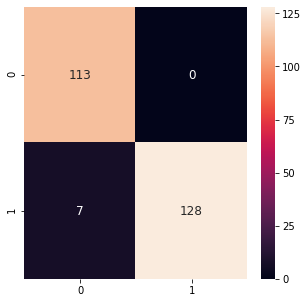

In [67]:
# Create your classifier
classifier = Classifier(MLP, hidden_layer_sizes=(100, 100), max_iter=2000, random_state=1)

classifier.train(X_train_new_red, y_train_new)
# Validate your classifier
confusion_matrix, _, _ = classifier.validate(X_val_new_red, y_val_new, multiclass=False)
print_confusion_matrix(confusion_matrix)

In [68]:
# Show qualitative results such as accuracy, k-fold validation, TSNE/PCA/Isomap plots, etc.
kf = KFold(n_splits=5)
kf.get_n_splits(X_train_new_red)
accs = []
f1s = []
classifier = Classifier(MLP, hidden_layer_sizes=(100, 100), max_iter=2000, random_state=1)
for train_index, test_index in kf.split(X_train_new_red):
    X_train, X_val = X_train_new_red[train_index], X_train_new_red[test_index]
    y_train, y_val = y_train_new[train_index], y_train_new[test_index]
    classifier.train(X_train, y_train)
    _, acc, f1 = classifier.validate(X_val, y_val, print_results=False)
    accs.append(acc)
    f1s.append(f1)

accs = np.asarray(accs)/100
f1s = np.asarray(f1s)

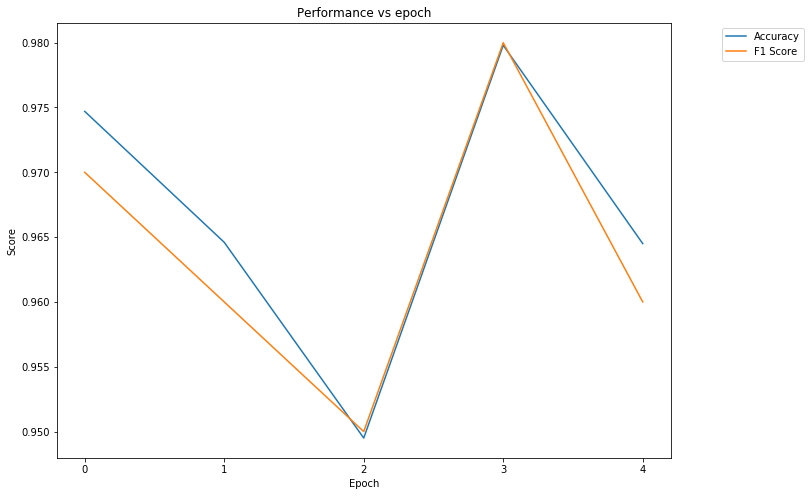

In [69]:
x_axis = np.arange(len(accs))
fig = plt.figure(figsize=(11,8))
ax = fig.add_subplot(111)

ax.plot(x_axis, accs, label='Accuracy')
ax.plot(x_axis, f1s, label='F1 Score')

plt.xticks(x_axis)
plt.xlabel('Epoch')
plt.ylabel('Score')

plt.title('Performance vs epoch')

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.15,1))
plt.show()

In [ ]:
k=3
X_TSNE_new = TSNE(n_components=k).fit_transform(X_new)
plot_scatterplot(X_TSNE_new, y_new, "Yale Dataset")

In [ ]:
print("Wrongly Classified Examples")
y_pred_new = classifier.classify(X_val_new_red)
wrong_classified = []
correct_classified_idx = []
labels = []
for i in range(len(y_pred_new)):
    if y_pred_new[i] != y_val_new[i]:
#         print(X_val_new[i].shape)
        x_new_3d = X_val_new[i].reshape((H, W, C))
        wrong_classified.append(x_new_3d)
        labels.append(y_val_new[i])
    else:
        correct_classified_idx.append(i)
wrong_classified = np.asarray(wrong_classified)
labels = np.asarray(labels)
disply_images(wrong_classified, labels, row=2, col=3)

print("Correctly Classified Examples")
correct_classified_idx = np.asarray(correct_classified_idx)
idx = np.random.choice(correct_classified_idx, 6)
correct_classified = []
labels = []
for idc in idx:
    x_new_3d = X_val_new[idc].reshape((H, W, C))
    correct_classified.append(x_new_3d)
    labels.append(y_val_new[idc])
correct_classified = np.asarray(correct_classified)
labels = np.asarray(labels)
disply_images(correct_classified, labels, row=2, col=3)

# Show quantitative results such as examples of correct prediction and wrong prediction